In [1]:
%matplotlib inline
import os
import time
import torch
import torchvision

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Custom Dataset Class

In [3]:
class MyDataset(Dataset):

    def __init__(self, csv_path, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = df["File Directory"]
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir[index],
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50

set_all_seeds(RANDOM_SEED)
#set_deterministic()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Custom Dataloader & Dataset

In [5]:
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
    transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


train_dataset = MyDataset(csv_path='df_train.csv',
                          transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use


valid_dataset = MyDataset(csv_path='df_val.csv',
                          transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)


test_dataset = MyDataset(csv_path='df_test.csv',
                         transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

In [6]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0])


# MLP

In [7]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, 100, bias=False),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # implement the layers, activation, etc. here
            torch.nn.Linear(100, 50, bias=False),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(50, num_classes)
        )
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits
    
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=3*64*64,
            num_hidden=100,
            num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

#################################
### Training
#################################

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS, # you can but don't need to change this
    train_loader=train_loader, # no need to change this
    valid_loader=valid_loader, # no need to change this
    test_loader=test_loader, # no need to change this
    optimizer=optimizer, # no need to change this
    device=DEVICE, # no need to change this
    logging_interval=100, # no need to change this
    scheduler=scheduler, ## optional
    scheduler_on='valid_acc') # optional)

Epoch: 001/050 | Batch 0000/0039 | Loss: 0.6917
Epoch: 001/050 | Train: 91.35% | Validation: 91.12%
Time elapsed: 1.42 min
Epoch: 002/050 | Batch 0000/0039 | Loss: 0.3133
Epoch: 002/050 | Train: 94.00% | Validation: 94.25%
Time elapsed: 2.08 min
Epoch: 003/050 | Batch 0000/0039 | Loss: 0.1792
Epoch: 003/050 | Train: 95.19% | Validation: 94.50%
Time elapsed: 2.74 min
Epoch: 004/050 | Batch 0000/0039 | Loss: 0.1588
Epoch: 004/050 | Train: 94.94% | Validation: 95.50%
Time elapsed: 3.42 min
Epoch: 005/050 | Batch 0000/0039 | Loss: 0.2170
Epoch: 005/050 | Train: 95.94% | Validation: 95.62%
Time elapsed: 4.10 min
Epoch: 006/050 | Batch 0000/0039 | Loss: 0.1914
Epoch: 006/050 | Train: 95.66% | Validation: 94.75%
Time elapsed: 4.79 min
Epoch: 007/050 | Batch 0000/0039 | Loss: 0.1526
Epoch: 007/050 | Train: 96.93% | Validation: 96.12%
Time elapsed: 5.45 min
Epoch: 008/050 | Batch 0000/0039 | Loss: 0.1086
Epoch: 008/050 | Train: 96.88% | Validation: 97.25%
Time elapsed: 6.11 min
Epoch: 009/050 |

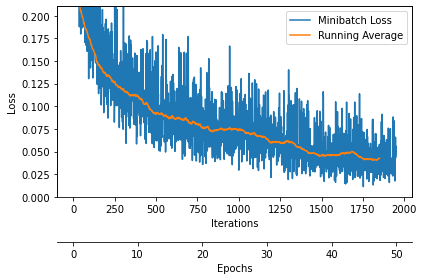

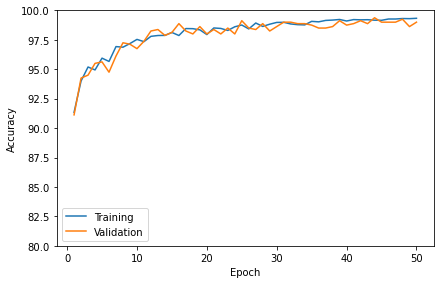

In [8]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

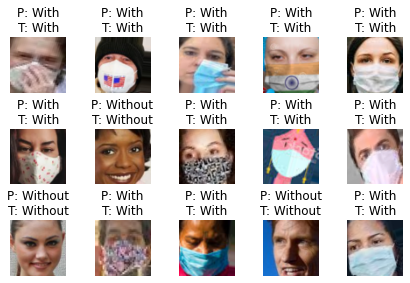

In [9]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'Without',
              1: 'With'
              }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

<function matplotlib.pyplot.show(close=None, block=None)>

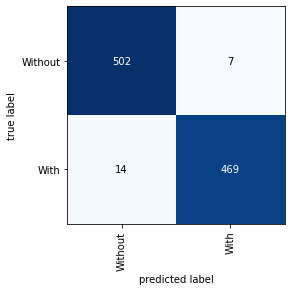

In [10]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show